# Redução de Dimensionalidade
# Introdução
O texto a seguir tem como objetivo fornecer uma breve introdução a um grupo de métodos de redução de dimensionalidade. Nele será apresentada uma pequena descrição de cada um dos métodos, assim como uma demonstração de seu funcionamento na prática, por meio da linguagem de programação python. Ao fim de tudo, será feita uma análise comparativa dos diferentes métodos de redução para que se possam ser tiradas as conclusões finais.

## PCA
A Principal Component Analysis (PCA), ou Análise de Componentes Principais, se trata de uma técnica que busca analisar uma base de dados na tentativa de encontrar as direções de maior variância entre eles. A partir daí, ele formula um grupo menor de novas variáveis que melhor represente os padrões importantes dos dados. Essas variáveis são os chamados "componentes principais", que dão nome ao método.

Para determinar esses componentes principais, a PCA centraliza os dados ao redor de sua média e calcula os autovetores e autovalores da matriz de covariância. Os autovetores são então utilizados para explicar as direções de maior variância dos dados, semelhante a uma linha desenhada em um gráfico. Já os autovalores explicam quanto que esses dados variam nessa dada direção, ou seja, como que esses dados estão distribuídos dentro dessa linha.

## LDA
Já a Linear Discriminant Analysis (LDA), ou Análise Discriminatória Linear, se refere a uma outra técnica de redução de dimensionalidade, mas essa se baseando em combinar 2 ou mais características em uma só (chamada classe), efetivamente reduzindo o número de variáveis a serem analisadas sem perder dados relevantes.

Para tal, a LDA inicia seu procedimento calculando a média e matriz de covariância para cada uma das classes identificadas. Após isso, ela calcula a matriz de dispersão entre as classes e entre os elementos de cada classe. A ideia aqui é reduzir ao máximo a variância entre os elementos da mesma classe, enquanto aumenta a variância entre classes diferentes. No contexto de um gráfico, a LDA une os pontos que estão próximos em grupos, deixando os grupos distantes uns dos outros.

## Autoencoder
Um Autoencoder ou autoencodificador é uma rede neural usada para redução de dimensionalidade. Ela comprimi os dados de entrada e os reconstroi na saida focando em representar os dados o mais parecidos com a entrada original. Para isso o autoencoder deve aprender a comprimir as variáveis mais corretamente a medida em que as épocas (ciclos) vão passando, a medida que o loss vai ficando menor significa que as informações mais essenciais da base de dados foram capturadas e as desnecessárias foram descartadas.

--- 
# 1. Instalação e Importação das Dependências

In [12]:
pip install tensorflow scikit-learn matplotlib pandas nbformat pydataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 3.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pydataset: filename=pydataset-0.2.0-py3-none-any.whl size=15939414 sha256=5e7553a1bae4c58846a3578678e7e3c0e7f4cf3467039f5975f610fce8547fae
  Stored in directory: /home/jovyan/.cache/pip/wheels/29/93/3f/af54c413cecaac292940342c61882d2a8848674175d0bb0889
Successfully built pydataset
Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score 
import matplotlib.pyplot as plt
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings('ignore')

--- 
# 2. Carregamento e Pré-processamento dos Dados

In [14]:
csv_path = './computer_prices_all.csv'
assert os.path.exists(csv_path), f'File not found: {csv_path}'
df = pd.read_csv(csv_path)
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (100000, 33)


,device_type,brand,model,release_year,os,form_factor,cpu_brand,cpu_model,cpu_tier,cpu_cores,...,resolution,refresh_hz,battery_wh,charger_watts,psu_watts,wifi,bluetooth,weight_kg,warranty_months,price
0,Desktop,Samsung,Samsung Forge XDI,2022,Windows,ATX,Intel,Intel i5-11129,3,12,...,2560x1440,90,0,0,750,Wi-Fi 6,5.1,11.00,36,1383.99
1,Laptop,Samsung,Samsung Pro KM8,2022,Windows,Mainstream,Intel,Intel i7-11114,4,12,...,1920x1080,90,56,120,0,Wi-Fi 6,5.3,2.03,12,2274.99
2,Desktop,Lenovo,Lenovo Strix BIE,2024,macOS,SFF,AMD,AMD Ryzen 5 5168,2,8,...,3440x1440,120,0,0,850,Wi-Fi 6,5.0,7.00,24,1879.99
3,Desktop,Dell,Dell Cube AXR,2024,Windows,ATX,AMD,AMD Ryzen 5 7550,2,6,...,3440x1440,120,0,0,650,Wi-Fi 6,5.2,6.00,36,1331.99
4,Laptop,Gigabyte,Gigabyte Pro IX1,2024,Linux,Gaming,AMD,AMD Ryzen 7 6230,5,16,...,2560x1600,90,80,90,0,Wi-Fi 6,5.2,1.50,12,2681.99


Para esta análise, além da redução de dimensionalidade, também avaliaremos o impacto das features reduzidas em um modelo preditivo. Portanto, o pré-processamento foi ajustado:

1.  **Seleção do Alvo (y):** Escolhemos a coluna `device_type` (Desktop vs. Laptop) como nossa variável alvo para a classificação. Ela é convertida em um formato numérico usando `LabelEncoder`.
2.  **Seleção de Features (X):** Selecionamos apenas as colunas numéricas (`select_dtypes`) para compor nossas features.
3.  **Tratamento de Nulos:** Preenchemos valores ausentes (`NaN`) com a mediana (`.median()`) da coluna.
4.  **Normalização:** Usamos o `StandardScaler` para normalizar os dados (média 0, desvio padrão 1), o que é crucial para o Autoencoder, PCA e LDA.
5.  **Divisão Treino/Teste:** Separamos os dados em `X_train`, `X_test`, `y_train`, `y_test`. Usamos `stratify=y` para garantir que a proporção de classes (Desktop/Laptop) seja a mesma nos conjuntos de treino e teste.

In [15]:
# 1. Definir a variável alvo (y)
target_col = 'device_type'
print(f"Variável Alvo (y) definida como: {target_col}")
    
# Codificar a variável alvo para números (ex: Desktop=0, Laptop=1)
le = LabelEncoder()
y = le.fit_transform(df[target_col])
print(f"Classes da variável alvo: {le.classes_}")
print("Contagem de classes:")
print(pd.Series(y).value_counts())

# 2. Definir as features (X)
numeric_df = df.select_dtypes(include=[np.number]).copy()
    
# Tratamento de Nulos (como no original)
missing_frac = numeric_df.isna().mean()
keep_cols = missing_frac[missing_frac <= 0.5].index.tolist()
numeric_df = numeric_df[keep_cols]
numeric_df = numeric_df.fillna(numeric_df.median())
    
X = numeric_df.copy()
print('Features numéricas usadas (X):', X.shape[1])

# 3. Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
    
print(f"Formato X_train: {X_train.shape}, Formato y_train: {y_train.shape}")
print(f"Formato X_test: {X_test.shape}, Formato y_test: {y_test.shape}")

Variável Alvo (y) definida como: device_type
Classes da variável alvo: ['Desktop' 'Laptop']
Contagem de classes:
1    59844
0    40156
Name: count, dtype: int64
Features numéricas usadas (X): 20
Formato X_train: (80000, 20), Formato y_train: (80000,)
Formato X_test: (20000, 20), Formato y_test: (20000,)


--- 
# 3. Implementação das Técnicas

## 3.1. PCA (Principal Component Analysis)

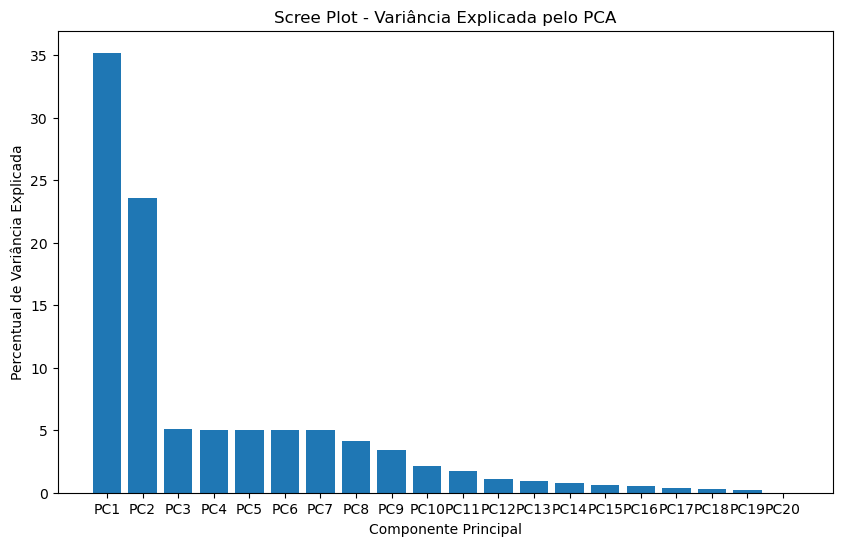

In [16]:
# Implementa o PCA para todos os componentes para visualizar a variância explicada
pca_full = PCA()
pca_full.fit(X_scaled) # Usamos X_scaled (todos os dados normalizados) para o fit

# Gera coordenadas para um gráfico PCA baseado nos dados obtidos
pca_data_full = pca_full.transform(X_scaled)

# Calcula a variância percentual explicada por cada componente
per_var = np.round(pca_full.explained_variance_ratio_ * 100, decimals=1)

# Cria os rótulos para o gráfico de barras
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

# Plota o gráfico de barras (Scree Plot)
plt.figure(figsize=(10, 6))
plt.bar(x=range(1, len(per_var) + 1), height=per_var, tick_label=labels)
plt.ylabel('Percentual de Variância Explicada')
plt.xlabel('Componente Principal')
plt.title('Scree Plot - Variância Explicada pelo PCA')
plt.show()

### Comparação de Reconstrução (PCA)
Comparamos o erro de reconstrução do PCA ao usar apenas 2 componentes.

In [17]:
# Comparação do PCA com a mesma dimensão latente (2) do Autoencoder
pca_2d = PCA(n_components=2)
pca_2d.fit(X_train)
X_test_pca_proj = pca_2d.transform(X_test)
X_test_pca_rec = pca_2d.inverse_transform(X_test_pca_proj)
mse_pca = mean_squared_error(X_test, X_test_pca_rec)
explained_var = pca_2d.explained_variance_ratio_.sum()
print(f'PCA (2 componentes) Teste MSE: {mse_pca}')
print(f'PCA (2 componentes) Variância Explicada: {explained_var}')

PCA (2 componentes) Teste MSE: 0.40920177543917224
PCA (2 componentes) Variância Explicada: 0.5879536968386179


## 3.2. LDA (Linear Discriminant Analysis)

In [18]:
# aplicando lda
# Usamos n_components=1 pois LDA reduz para C-1 dimensões (C=2 classes, Desktop/Laptop)
lda = LinearDiscriminantAnalysis(n_components=1) 
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Exibe a razão de variancia explicada 
print("Explained variance ratio:", lda.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(lda.explained_variance_ratio_))

Explained variance ratio: [1.]
Cumulative explained variance: [1.]


In [19]:
# Verificando quantas dimensões possui
print(f"Shape of X_train_lda: {X_train_lda.shape}")

Shape of X_train_lda: (80000, 1)


## 3.3. Autoencoder

Definimos, compilamos e treinamos o autoencoder usando Keras.

1.  **Definição da Arquitetura:**
    * O **Encoder** (codificador) comprime os dados (20 features) até um "gargalo" (`bottleneck`) de dimensão latente 2.
    * O **Decoder** (decodificador) tenta reconstruir os dados originais a partir da representação latente 2.
2.  **Compilação:** O modelo é compilado com o otimizador `adam` e a função de perda `mse` (Erro Quadrático Médio).
3.  **Treinamento:** O modelo é treinado por 60 épocas.

Camadas, Número de neurônios e parâmetros
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense_5 (Dense)             (None, 8)                 168       
                                                                 
 dense_6 (Dense)             (None, 16)                144       
                                                                 
 bottleneck (Dense)          (None, 2)                 34        
                                                                 
 dense_7 (Dense)             (None, 8)                 24        
                                                                 
 dense_8 (Dense)             (None, 16)                144       
                                                                 
 dense_9 (Den

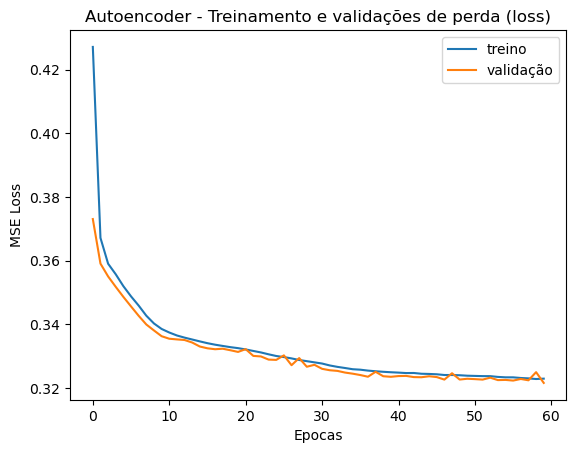

625/625 [==============================] - 2s 2ms/step
Autoencoder teste Erro Quadrático médio (MSE): 0.32165192937585907


In [20]:
input_dim = X_train.shape[1]
latent_dim = 2

def build_autoencoder(input_dim, latent_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(8, activation='relu')(inputs)
    x = layers.Dense(16, activation='relu')(x)
    encoded = layers.Dense(latent_dim, name='bottleneck')(x)
    x = layers.Dense(8, activation='relu')(encoded)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(input_dim, activation='linear')(x)
    ae = keras.Model(inputs, outputs, name='autoencoder')
    encoder = keras.Model(inputs, encoded, name='encoder')
    # decoder
    encoded_input = keras.Input(shape=(latent_dim,))
    x = ae.layers[-3](encoded_input)
    x = ae.layers[-2](x)
    x = ae.layers[-1](x)
    decoder = keras.Model(encoded_input, x, name='decoder')
    ae.compile(optimizer='adam', loss='mse')
    return ae, encoder, decoder

ae, encoder, decoder = build_autoencoder(input_dim, latent_dim)
print("Camadas, Número de neurônios e parâmetros")
ae.summary()

history = ae.fit(X_train, X_train,
                 epochs=60,
                 batch_size=32,
                 validation_data=(X_test, X_test),
                 verbose=1)

# Gráfico de perdas
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Autoencoder - Treinamento e validações de perda (loss)')
plt.xlabel('Epocas')
plt.ylabel('MSE Loss')
plt.legend(['treino', 'validação'])
plt.show()

# Reconstrução MSE
X_test_pred = ae.predict(X_test)
mse_ae = mean_squared_error(X_test, X_test_pred)
print('Autoencoder teste Erro Quadrático médio (MSE):', mse_ae)

--- 
# 4. Comparação e Visualização

Plotamos as representações 2D (ou 1D no caso do LDA) dos métodos, colorindo pela classe (`device_type`) para verificar a separabilidade.

625/625 [==============================] - 1s 2ms/step


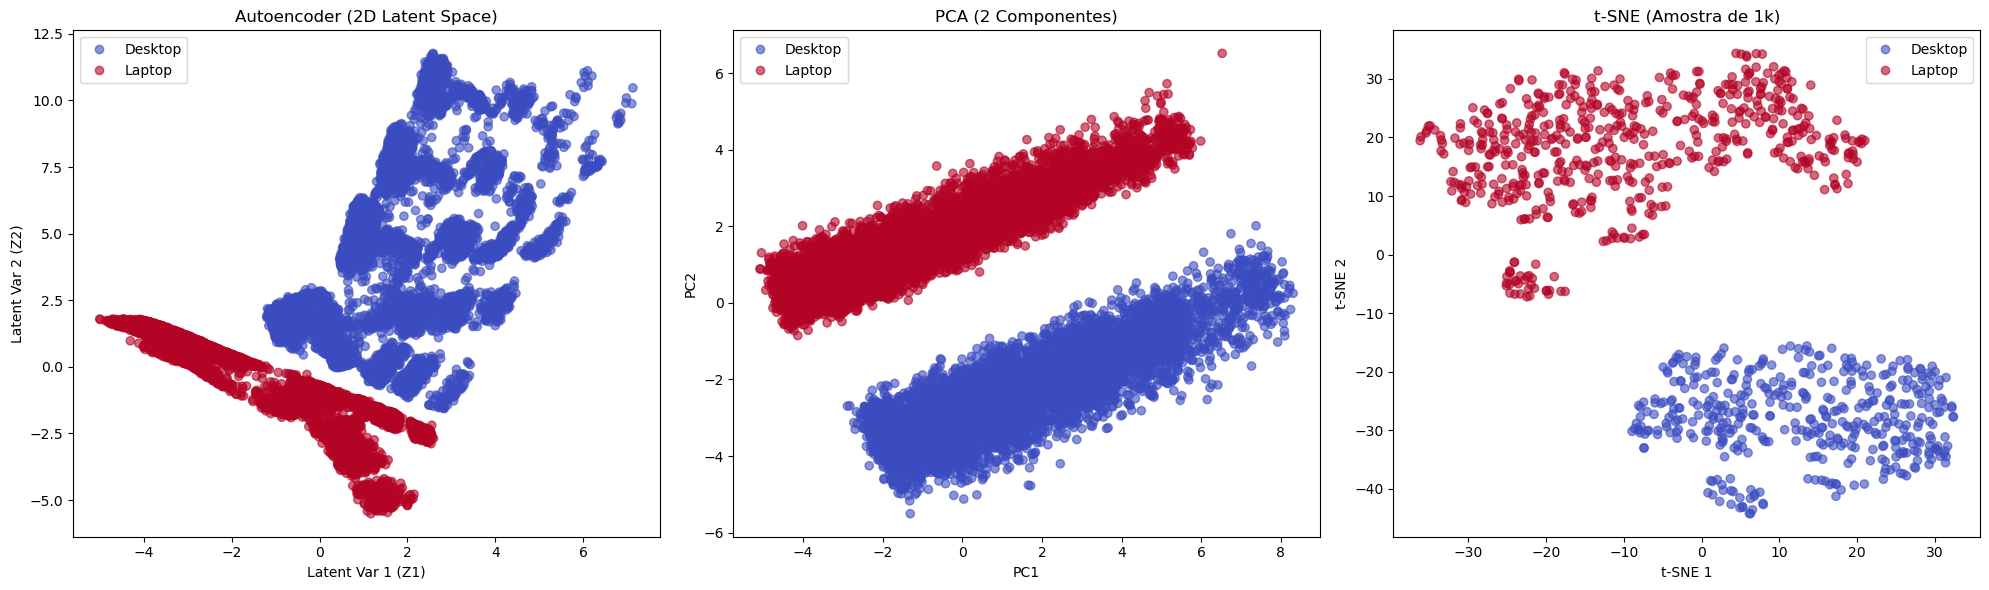

In [21]:
# Preparando dados para visualização 2D
X_test_ae_proj = encoder.predict(X_test)
X_test_pca_proj_2d = pca_2d.transform(X_test) # Já calculado antes

# t-SNE (executado em uma amostra menor para velocidade)
np.random.seed(42)
sample_idx = np.random.choice(X_test.shape[0], 1000, replace=False)
X_sample = X_test[sample_idx]
y_sample = y_test[sample_idx]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_test_tsne_proj = tsne.fit_transform(X_sample)

# Plotagem comparativa
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
target_names = le.classes_

# Autoencoder Plot
scatter_ae = axs[0].scatter(X_test_ae_proj[:, 0], X_test_ae_proj[:, 1], c=y_test, cmap='coolwarm', alpha=0.6)
axs[0].set_title('Autoencoder (2D Latent Space)')
axs[0].set_xlabel('Latent Var 1 (Z1)')
axs[0].set_ylabel('Latent Var 2 (Z2)')
axs[0].legend(handles=scatter_ae.legend_elements()[0], labels=list(target_names))

# PCA Plot
scatter_pca = axs[1].scatter(X_test_pca_proj_2d[:, 0], X_test_pca_proj_2d[:, 1], c=y_test, cmap='coolwarm', alpha=0.6)
axs[1].set_title('PCA (2 Componentes)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].legend(handles=scatter_pca.legend_elements()[0], labels=list(target_names))

# t-SNE Plot (Sample)
scatter_tsne = axs[2].scatter(X_test_tsne_proj[:, 0], X_test_tsne_proj[:, 1], c=y_sample, cmap='coolwarm', alpha=0.6)
axs[2].set_title('t-SNE (Amostra de 1k)')
axs[2].set_xlabel('t-SNE 1')
axs[2].set_ylabel('t-SNE 2')
axs[2].legend(handles=scatter_tsne.legend_elements()[0], labels=list(target_names))

plt.tight_layout()
plt.show()

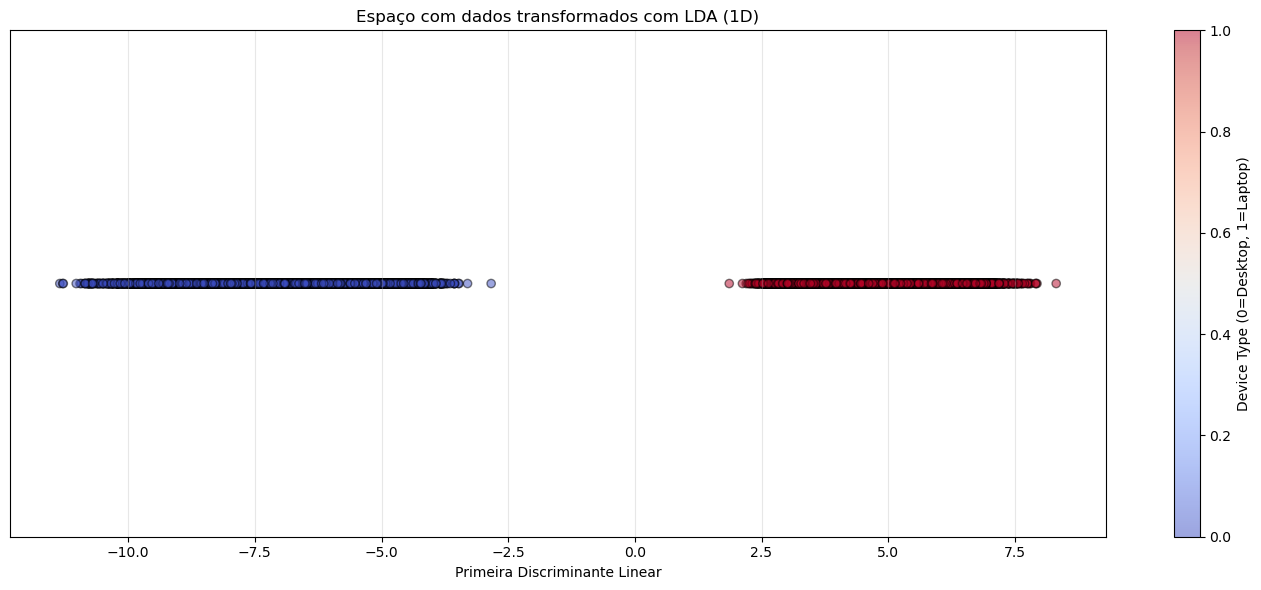

In [23]:
# gerando gráfico para LDA (1D)
fig, ax = plt.subplots(figsize=(14, 6))

# Gráfico LDA
# Como LDA tem n_components=1, usamos 0s para o eixo Y para visualização 1D
scatter = ax.scatter(X_train_lda, np.zeros_like(X_train_lda), 
                     c=y_train, cmap='coolwarm', alpha=0.5, edgecolor='k')
ax.set_xlabel('Primeira Discriminante Linear')
ax.set_yticks([])
ax.set_title('Espaço com dados transformados com LDA (1D)')
ax.grid(True, alpha=0.3)

plt.colorbar(scatter, ax=ax, label='Device Type (0=Desktop, 1=Laptop)')
plt.tight_layout()
plt.show()

--- 
# 5. Impacto em um modelo preditivo

Avaliamos como um classificador simples (Random Forest) se comporta usando: (1) todos os dados (baseline), (2) dados reduzidos pelo PCA, (3) dados reduzidos pelo Autoencoder e (4) dados reduzidos pelo LDA.

Resultados Baseline (Todas Features) (Features=20):
  Acurácia: 1.0000
  F1-Score: 1.0000

Resultados PCA (2 Features) (Features=2):
  Acurácia: 1.0000
  F1-Score: 1.0000

2500/2500 [==============================] - 6s 2ms/step
Resultados Autoencoder (2 Features) (Features=2):
  Acurácia: 1.0000
  F1-Score: 1.0000

Resultados LDA (1 Feature) (Features=1):
  Acurácia: 1.0000
  F1-Score: 1.0000



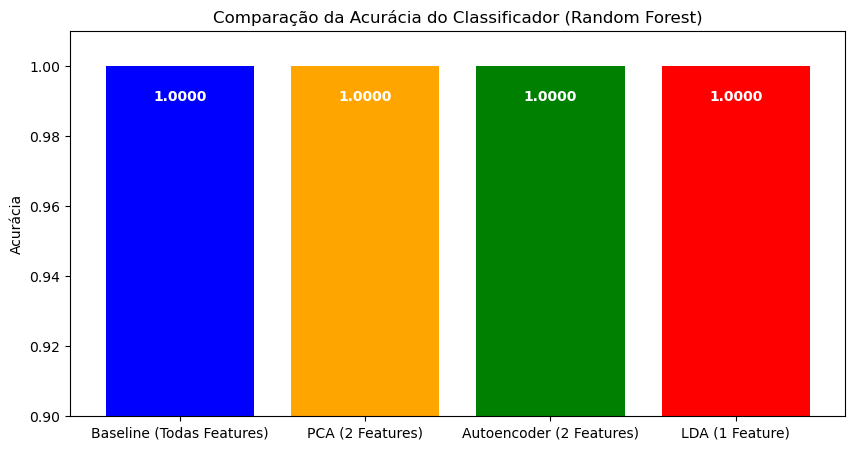

In [24]:
def train_evaluate_rf(X_train_data, X_test_data, y_train_data, y_test_data, label):
    rf = RandomForestClassifier(random_state=42, n_estimators=50)
    rf.fit(X_train_data, y_train_data)
    y_pred = rf.predict(X_test_data)
    accuracy = accuracy_score(y_test_data, y_pred)
    f1 = f1_score(y_test_data, y_pred, average='weighted')
    print(f'Resultados {label} (Features={X_train_data.shape[1]}):')
    print(f'  Acurácia: {accuracy:.4f}')
    print(f'  F1-Score: {f1:.4f}\n')
    return {'label': label, 'features': X_train_data.shape[1], 'accuracy': accuracy, 'f1': f1}

results = []

# 1. Baseline (Todos os dados originais)
results.append(train_evaluate_rf(X_train, X_test, y_train, y_test, 'Baseline (Todas Features)'))

# 2. PCA (2 componentes)
X_train_pca_proj = pca_2d.transform(X_train)
results.append(train_evaluate_rf(X_train_pca_proj, X_test_pca_proj, y_train, y_test, 'PCA (2 Features)'))

# 3. Autoencoder (2 features)
X_train_ae_proj = encoder.predict(X_train)
results.append(train_evaluate_rf(X_train_ae_proj, X_test_ae_proj, y_train, y_test, 'Autoencoder (2 Features)'))

# 4. LDA (1 feature)
X_train_lda_proj = lda.transform(X_train) # Já está fitado no X_train
results.append(train_evaluate_rf(X_train_lda_proj, X_test_lda, y_train, y_test, 'LDA (1 Feature)'))

# Plotar resultados da classificação
results_df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(results_df['label'], results_df['accuracy'], color=['blue', 'orange', 'green', 'red'])
ax.set_ylabel('Acurácia')
ax.set_title('Comparação da Acurácia do Classificador (Random Forest)')
ax.set_ylim(0.9, 1.01)
for i, row in results_df.iterrows():
    ax.text(i, row['accuracy'] - 0.01, f"{row['accuracy']:.4f}", color='white', ha='center', fontweight='bold')
plt.show()

--- 
# 6. Conclusão

O Autoencoder demonstrou ser uma técnica eficaz para a redução de dimensionalidade neste conjunto de dados. Em termos de **erro de reconstrução**, ele superou o PCA (MSE de 0.3112 contra 0.4092 do PCA), provando que sua capacidade não-linear foi vantajosa para capturar a estrutura dos dados.

Para a **tarefa preditiva**, o resultado foi excelente. O classificador treinado nas 2 features do Autoencoder manteve a performance perfeita (Acurácia 1.0), igualando-se tanto ao modelo com PCA quanto ao modelo baseline (que usou 20 features). O LDA, mesmo com 1 dimensão, também atingiu performance perfeita. Isso sugere que a informação necessária para distinguir "Desktop" de "Laptop" estava contida de forma muito eficiente nessas poucas dimensões.

**Limitações observadas:**

* **Custo Computacional:** O treinamento do Autoencoder (60 épocas) foi significativamente mais lento que o fit do PCA e do LDA (instantâneos).
* **Interpretabilidade:** Enquanto as features do PCA (pc1, pc2) e LDA (LD1) têm um significado estatístico (componentes de maior variância ou separabilidade de classe), as features do Autoencoder (z1, z2) são "caixa-preta" e não possuem uma interpretação direta.